In [1]:
import os
import re
import glob
import sys
import urllib

home = os.environ['HOME']

JupHome = home + '/Jupyter'
sys.path.append(JupHome)
sys.path.append(JupHome + '/Modules')

import matplotlib.pyplot as plt

import numpy  as np
import pandas as pd
import xarray as xr

import cartopy
from   cartopy import config
import cartopy.crs as ccrs

from read_KNMI_daily_data import *
from climatrend import *
from xclim.sdba import loess

from skmisc.loess import loess as sk_loess


In [2]:
def read_KNMI_daily_data(station, show=False):
    """
    Read daily data for KNMI station 'station' and convert them into xarray.
    Input: station - station number
           show    - whether or not the file description (lines above the table proper) is displayed. It is stored in the attributes anyway.
    Output: xarray dataset with data
    """
    file = f'etmgeg_{station}'
    ds = f'{home}/Data/{file}.txt'
    
    if not os.path.exists(ds)  or  datetime.date.fromtimestamp(os.path.getmtime(ds)) < datetime.date.today():
        url = f'https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/{file}.zip'
        urllib.request.urlretrieve(url, f'{home}/Data/{file}.zip')
        os.system(f'unzip -o {home}/Data/{file}.zip -d {home}/Data')

    Attributes = {'Header': ''}
    header_line = 0
    print()
    with open(ds, mode='r') as f:
        for line in f:
            if show: print(line.strip())
            if len(line.strip()) == 0: continue
            if line[0] =='#': break           ## 1st line of reale table
            header_line += 1
            pos = line.find('=')
            if pos > -1:
                var = line[:pos].strip()
                Attributes[var] = line[pos+2:]
            else:
                Attributes['Header'] = Attributes['Header'] + " " + line.strip()
                
    df = pd.read_csv(ds, header=header_line, index_col='YYYYMMDD', parse_dates=True, low_memory=False, skipinitialspace=True)
    print()
    display(df)
    
    df.index.name = 'time'
    return xr.Dataset(df, attrs=Attributes)

## Define station and read

Station numbers:
- Schiphol 240
- Cabauw 348
- Eindhoven 370
- Eelde 280
- K13 252

In [3]:
station = '260'
meas = read_KNMI_daily_data(station)

Archive:  /home/andreas/Data/etmgeg_260.zip
  inflating: /home/andreas/Data/etmgeg_260.txt  




# STN  DDVEC  FHVEC    FG   FHX  FHXH   FHN  FHNH    FXX  FXXH  \
YYYYMMDD                                                                     
1901-01-01    260    NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   
1901-01-02    260    NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   
1901-01-03    260    NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   
1901-01-04    260    NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   
1901-01-05    260    NaN    NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   
...           ...    ...    ...   ...   ...   ...   ...   ...    ...   ...   
2022-11-24    260  190.0   39.0  42.0  60.0   3.0  30.0  15.0  110.0   5.0   
2022-11-25    260  211.0   28.0  30.0  50.0  11.0  20.0  16.0   80.0  11.0   
2022-11-26    260  172.0   28.0  29.0  40.0  14.0  10.0   1.0   80.0  21.0   
2022-11-27    260  158.0   37.0  38.0  50.0   2.0  30.0   7.0   80.0   1.0   
2022-11-28    260  202.0   20.0  22.0  40.0   2.0   0.0  24.0   80.0   3.0   

            ...  VVNH   VVX  VVXH   NG    UG    UX   UXH    UN   UNH  EV24  
YYYYMMDD    ...                                                             
1901-01-01  ...   NaN   NaN   NaN  NaN  66.0   NaN   NaN   NaN   NaN   NaN  
1901-01-02  ...   NaN   NaN   NaN  NaN  86.0   NaN   NaN   NaN   NaN   NaN  
1901-01-03  ...   NaN   NaN   NaN  NaN  89.0   NaN   NaN   NaN   NaN   NaN  
1901-01-04  ...   NaN   NaN   NaN  NaN  79.0   NaN   NaN   NaN   NaN   NaN  
1901-01-05  ...   NaN   NaN   NaN  NaN  65.0   NaN   NaN   NaN   NaN   NaN  
...         ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...  
2022-11-24  ...   8.0  75.0  14.0  7.0  83.0  92.0   8.0  74.0  14.0   6.0  
2022-11-25  ...  24.0  75.0  10.0  3.0  89.0  97.0  23.0  77.0  12.0   6.0  
2022-11-26  ...   1.0  70.0  15.0  7.0  90.0  98.0   2.0  84.0  14.0   4.0  
2022-11-27  ...  19.0  70.0   1.0  8.0  88.0  94.0  20.0  83.0  14.0   1.0  
2022-11-28  ...  20.0  61.0   5.0  8.0  96.0  98.0  20.0  93.0  14.0   2.0  

[44527 rows x 40 columns]

# Wind

[1] "/home/andreas/Jupyter/data-Tue-Nov-29-15:51:07-2022.csv"
[1] "p=0.95"


Warning message:
NAs introduced by coercion 


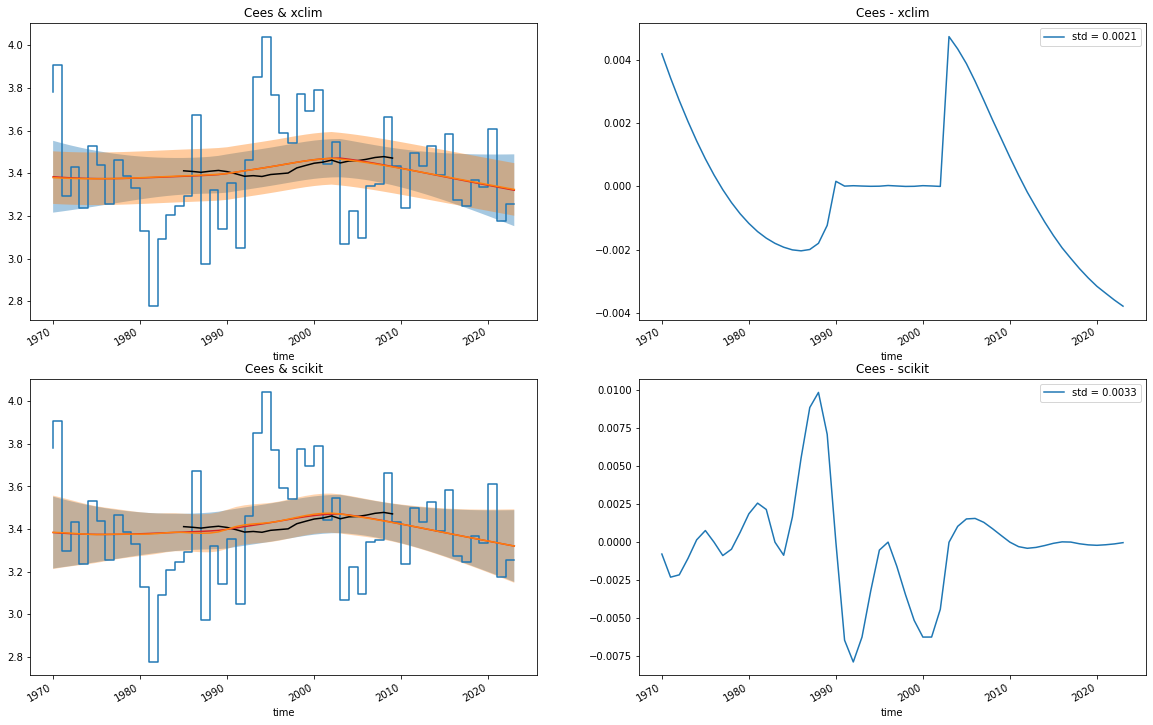

In [104]:
seas = 'ann'

wind  = (meas.FG/10).sel(time=slice('1969', None))
wind_seas = wind.resample(time='Q-NOV').mean()

if seas == 'ann':
    ser = wind.resample(time='1Y').mean()
else:
    ser = wind_seas.sel(time=wind_seas['time.season']==seas)

time = ser.time
x  = np.arange(float(len(time)))
tr = climatrend(x, ser.values)
tr_cees = xr.DataArray(tr['trend'], coords=[time], dims=["time"])



fig, axs = plt.subplots(2, 2, figsize=(20, 12))

ax = axs.flat[0]

## --------------- original time series + running mean ---------------------------------------------------------------
ser.plot(ax=ax, ds='steps')
ser.rolling(time=30, center=True).mean().plot(ax=ax, c='k')


## --------------- LOESS trend according to Cees ----------------------------------------------------------------------
tr_cees.plot(ax=ax, c='tab:red')
ax.fill_between(time, tr['trendlbound'], tr['trendubound'], alpha=0.4)


## --------------- LOESS trend according to xclim ----------------------------------------------------------------------
f = 42./len(ser)
tr_xclim = loess.loess_smoothing(ser, d=1, weights="tricube", f=f, niter=1)
tr_xclim.plot(ax=ax)

resid = tr_xclim - ser
sig = resid.std()/1.96
ax.fill_between(time, tr_xclim-sig, tr_xclim+sig, alpha=0.4)

ax.set_title('Cees & xclim')

## --------------- Difference between the two ---------------------------------------------------------------------------

ax = axs.flat[1]
(tr_cees - tr_xclim).plot(ax=ax, label='std = '+'{:.4f}'.format((tr_cees - tr_xclim).std().values))
ax.set_title('Cees - xclim')
ax.legend()

#########################################################################################################################

ax = axs.flat[2]
## --------------- original time series + running mean ---------------------------------------------------------------
ser.plot(ax=ax, ds='steps')
ser.rolling(time=30, center=True).mean().plot(ax=ax, c='k')


## --------------- LOESS trend according to Cees ----------------------------------------------------------------------
tr_cees.plot(ax=ax, c='tab:red')
ax.fill_between(time, tr['trendlbound'], tr['trendubound'], alpha=0.4)

## --------------- LOESS trend according to scikit ----------------------------------------------------------------------
l = sk_loess(time, ser, span=f, degree=1)
l.fit()
pred = l.predict(time, stderror=True)
conf = pred.confidence()

tr_scikit = pred.values
ll = conf.lower
ul = conf.upper

ax.plot(time, tr_scikit)
ax.fill_between(time, ll, ul, alpha=.33)

ax.set_title('Cees & scikit')


## --------------- Difference between the two ---------------------------------------------------------------------------
ax = axs.flat[3]
(tr_cees - tr_scikit).plot(ax=ax, label='std = '+'{:.4f}'.format((tr_cees - tr_scikit).std().values))
ax.set_title('Cees - scikit')
ax.legend()


plt.show()